# Clinical Data Analysis: GSE96058 (Breast Cancer)

**Goal:**  
Explore and model the clinical metadata (one-hot encoded) from the large GSE96058 breast cancer RNA-seq dataset, applying traditional analytics and AI/ML to extract biological/clinical insights.

Dataset: `GSE96058_clinical_onehot.csv`


In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from dotenv import load_dotenv
from pathlib import Path
from scipy.stats import kruskal

import warnings
warnings.filterwarnings('ignore')


## Data Loading
Loading the preprocessed data.

In [2]:
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")


repo_root = find_repo_root()
path = repo_root / os.getenv("CLINICAL")



df = pd.read_csv(path, index_col=0)
print(f"Shape: {df.shape}")


Shape: (3409, 34)


In [3]:
from IPython.display import display

styled = df.head().style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)
display(styled)

,OG_last_update_date,OG_instrument model,age at diagnosis,tumor size,lymph node group,lymph node status,er status,pgr status,her2 status,ki67 status,nhg,er prediction mgc,pgr prediction mgc,her2 prediction mgc,ki67 prediction mgc,nhg prediction mgc,er prediction sgc,pgr prediction sgc,her2 prediction sgc,ki67 prediction sgc,OG_pam50 subtype,overall survival days,overall survival event,endocrine treated,chemo treated,OHE_last_update_date__Mar 12 2018,OHE_last_update_date__May 04 2022,OHE_instrument model__HiSeq 2000,OHE_instrument model__NextSeq 500,OHE_pam50 subtype__Basal,OHE_pam50 subtype__Her2,OHE_pam50 subtype__LumA,OHE_pam50 subtype__LumB,OHE_pam50 subtype__Normal
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F1,May 04 2022,HiSeq 2000,43,9.000000,0.000000,0.000000,nan,nan,0.000000,nan,3.000000,0.000000,0.000000,0.000000,1.000000,3,0.000000,0.000000,0.000000,1.000000,Basal,2367,0.000000,0.000000,1.000000,0,1,1,0,1,0,0,0,0
F2,May 04 2022,HiSeq 2000,48,14.000000,2.000000,1.000000,1.000000,1.000000,0.000000,nan,2.000000,1.000000,1.000000,0.000000,0.000000,2,1.000000,1.000000,0.000000,0.000000,LumA,2367,0.000000,1.000000,1.000000,0,1,1,0,0,0,1,0,0
F3,May 04 2022,HiSeq 2000,69,27.000000,3.000000,1.000000,1.000000,1.000000,0.000000,nan,3.000000,1.000000,1.000000,0.000000,1.000000,3,1.000000,1.000000,0.000000,1.000000,LumB,2168,1.000000,1.000000,1.000000,0,1,1,0,0,0,0,1,0
F4,May 04 2022,HiSeq 2000,39,51.000000,2.000000,1.000000,1.000000,nan,1.000000,nan,3.000000,1.000000,1.000000,1.000000,1.000000,3,1.000000,1.000000,1.000000,1.000000,LumA,2416,0.000000,1.000000,1.000000,0,1,1,0,0,0,1,0,0
F5,May 04 2022,HiSeq 2000,73,60.000000,3.000000,1.000000,1.000000,nan,0.000000,nan,2.000000,1.000000,1.000000,0.000000,0.000000,2,1.000000,1.000000,0.000000,0.000000,Normal,2389,0.000000,1.000000,0.000000,0,1,1,0,0,0,0,0,1


In [4]:
display(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 3409 entries, F1 to F3265repl
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OG_last_update_date                3409 non-null   object 
 1   OG_instrument model                3409 non-null   object 
 2   age at diagnosis                   3409 non-null   int64  
 3   tumor size                         3374 non-null   float64
 4   lymph node group                   3308 non-null   float64
 5   lymph node status                  3308 non-null   float64
 6   er status                          3189 non-null   float64
 7   pgr status                         3051 non-null   float64
 8   her2 status                        3281 non-null   float64
 9   ki67 status                        1591 non-null   float64
 10  nhg                                3344 non-null   float64
 11  er prediction mgc                  3409 non-null   floa

None

In [5]:
print("\nNumber of duplicated rows:", df.duplicated().sum())


Number of duplicated rows: 0


Columns with missing data:


ki67 status          1818
pgr status            358
er status             220
her2 status           128
lymph node group      101
lymph node status     101
nhg                    65
tumor size             35
endocrine treated      22
chemo treated          21
dtype: int64

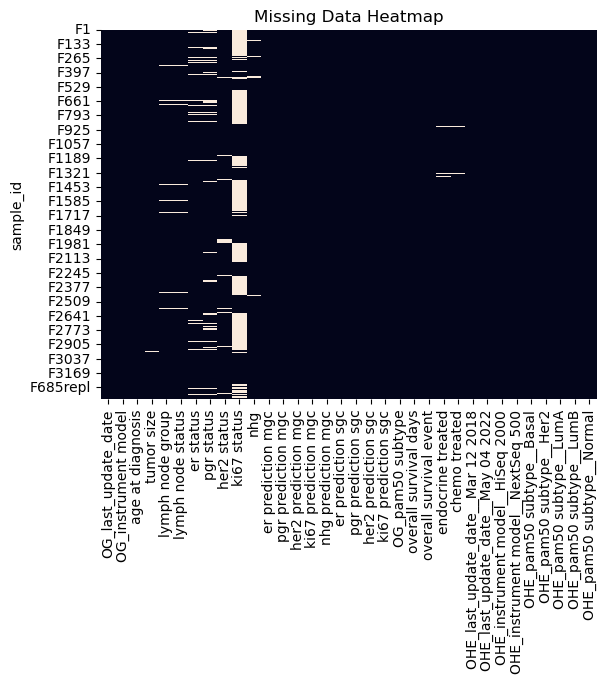

In [6]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing data:")
display(missing)

sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

## Binary Columns

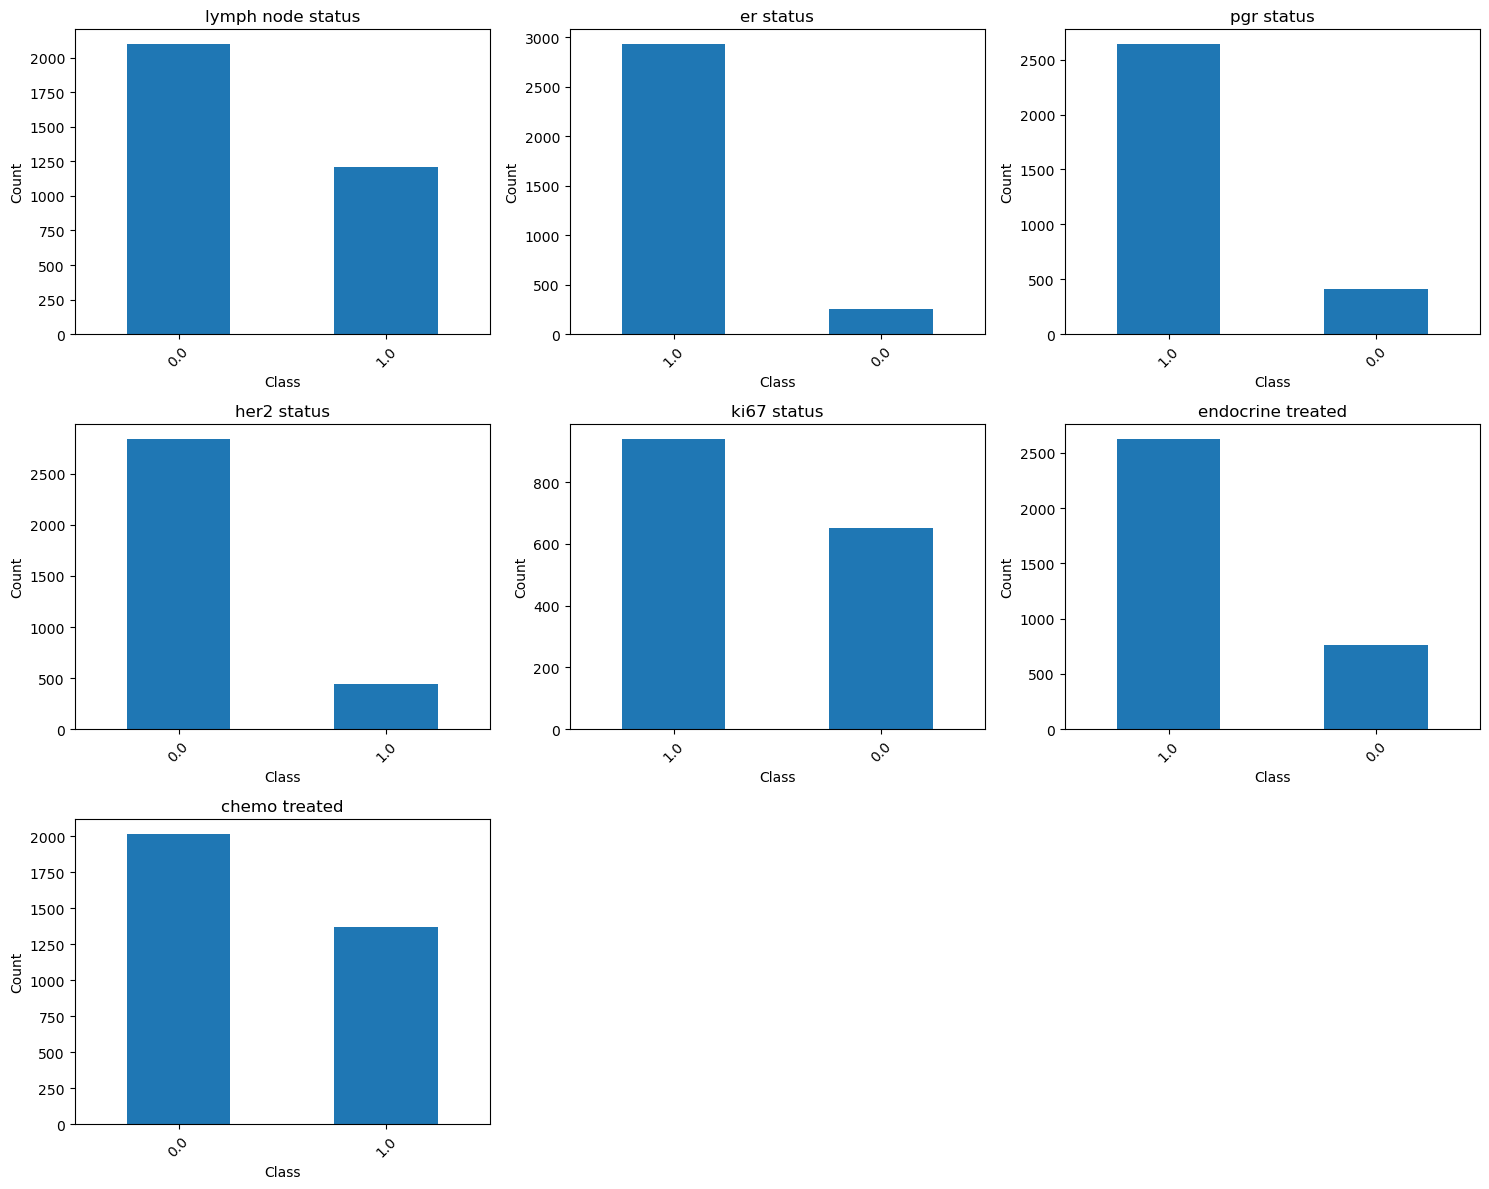

In [7]:
categorical = [col for col in df.columns if (
    'treated' in col or 'status' in col or 'response' in col
) and df[col].nunique() <= 20] 

n_cols = 3
n_rows = math.ceil(len(categorical) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

for idx, col in enumerate(categorical):
    r, c = divmod(idx, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]
    df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.set_xlabel("Class")
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(len(categorical), n_cols*n_rows):
    r, c = divmod(i, n_cols)
    fig.delaxes(axes[r, c] if n_rows > 1 else axes[c])

plt.tight_layout()
plt.show()


## Numerical Columns


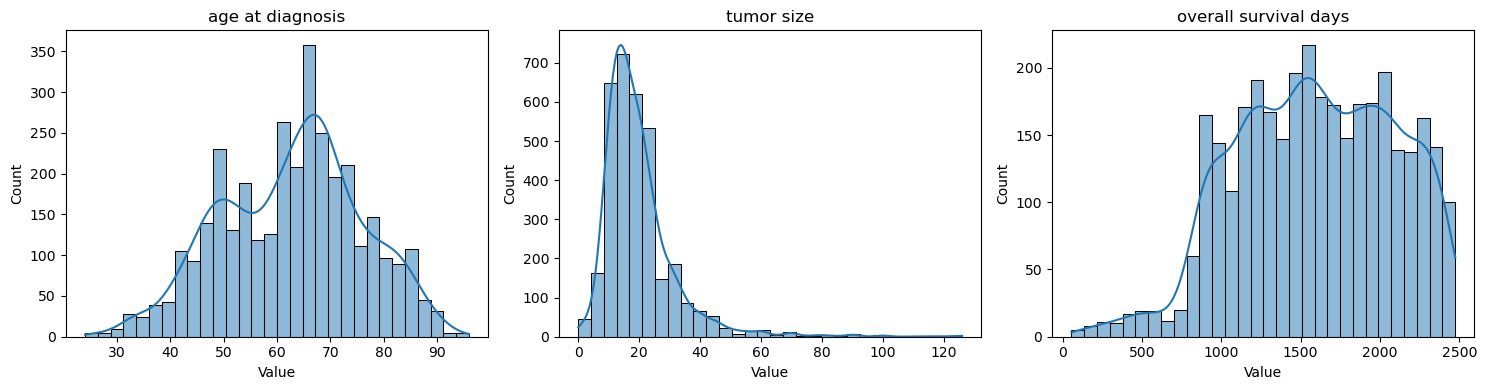

In [8]:
continuous_nonbinary = ['age at diagnosis', 'tumor size', 'overall survival days']

n_cols = 3
n_rows = math.ceil(len(continuous_nonbinary) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

for idx, col in enumerate(continuous_nonbinary):
    r, c = divmod(idx, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]
    sns.histplot(df[col].dropna(), kde=True, ax=ax, bins=30)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")

# Hide unused subplots
for i in range(len(continuous_nonbinary), n_cols * n_rows):
    r, c = divmod(i, n_cols)
    fig.delaxes(axes[r, c] if n_rows > 1 else axes[c])

plt.tight_layout()
plt.show()

## Ordinal Variables

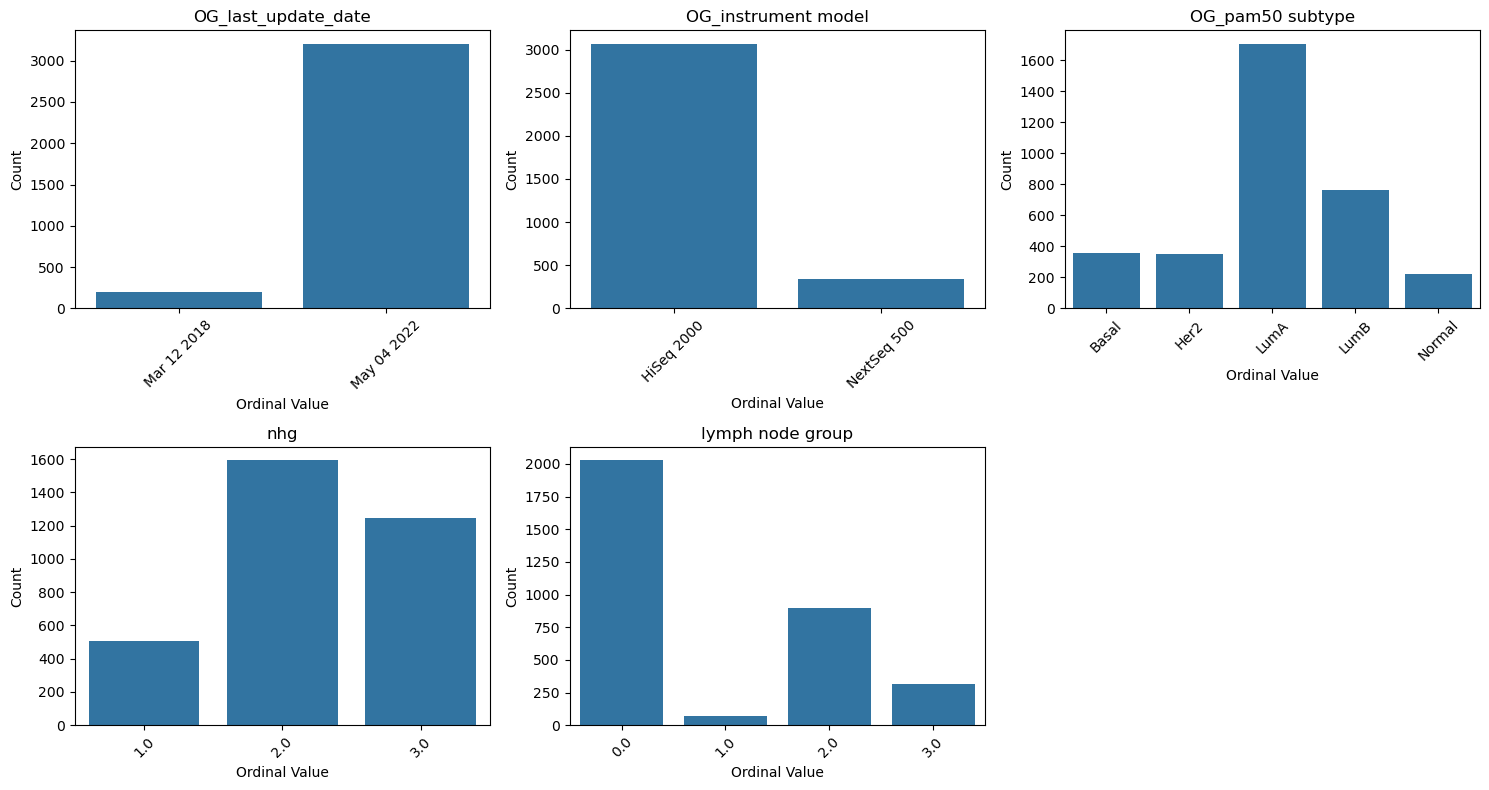

In [9]:
ordinal_cols = [col for col in df.columns if col.startswith("OG_")]
ordinal_cols += ['nhg', 'lymph node group']
n_cols = 3
n_rows = math.ceil(len(ordinal_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

for idx, col in enumerate(ordinal_cols):
    r, c = divmod(idx, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]
    order = sorted(df[col].dropna().unique())
    sns.countplot(x=col, data=df, order=order, ax=ax)
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.set_xlabel("Ordinal Value")
    ax.tick_params(axis='x', rotation=45)

# Hide unused subplots
for i in range(len(ordinal_cols), n_cols * n_rows):
    r, c = divmod(i, n_cols)
    fig.delaxes(axes[r, c] if n_rows > 1 else axes[c])

plt.tight_layout()
plt.show()


## Correlation & Pair-Wise Analysis

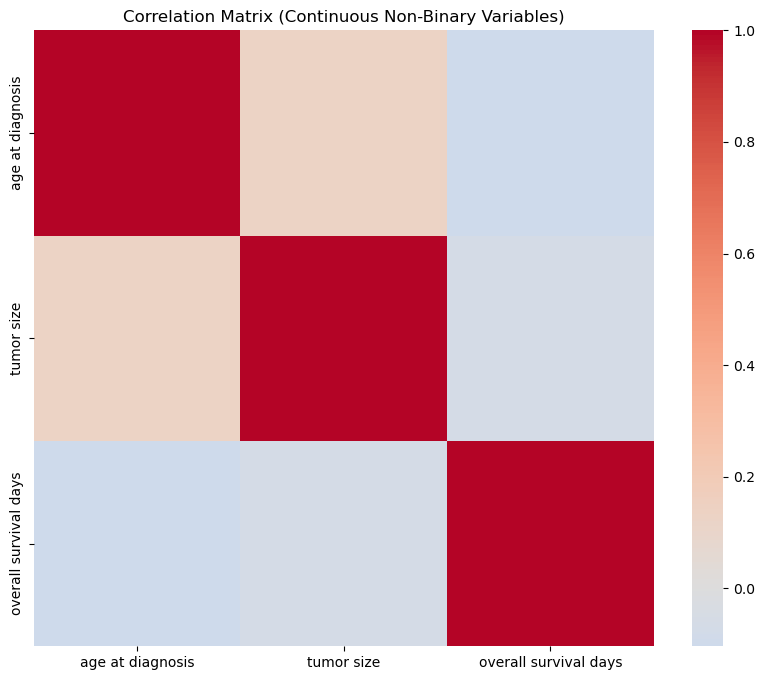

In [10]:
corr = df[continuous_nonbinary].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Continuous Non-Binary Variables)")
plt.show()


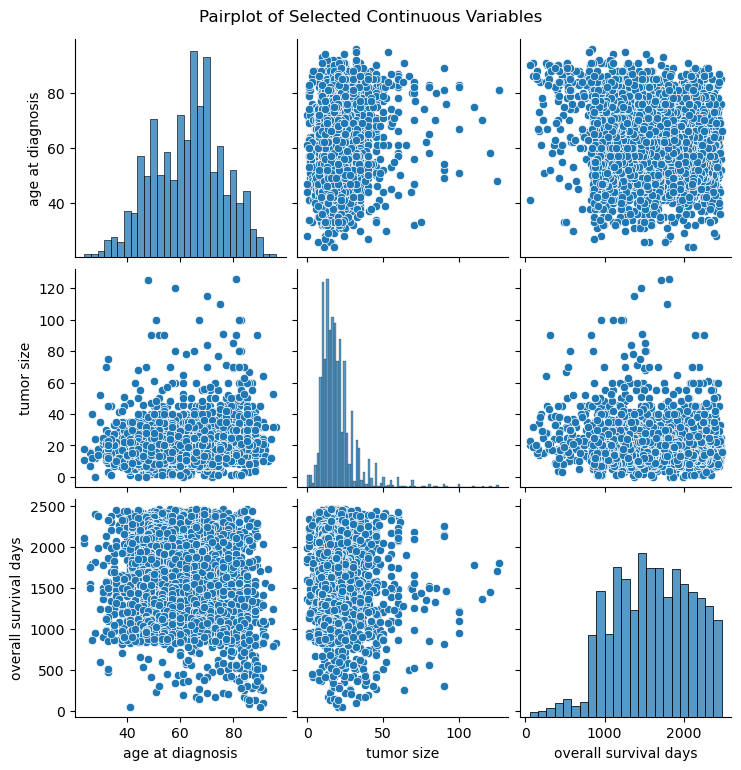

In [11]:
sample_cols = continuous_nonbinary
sns.pairplot(df[sample_cols].dropna())
plt.suptitle("Pairplot of Selected Continuous Variables", y=1.02)
plt.show()


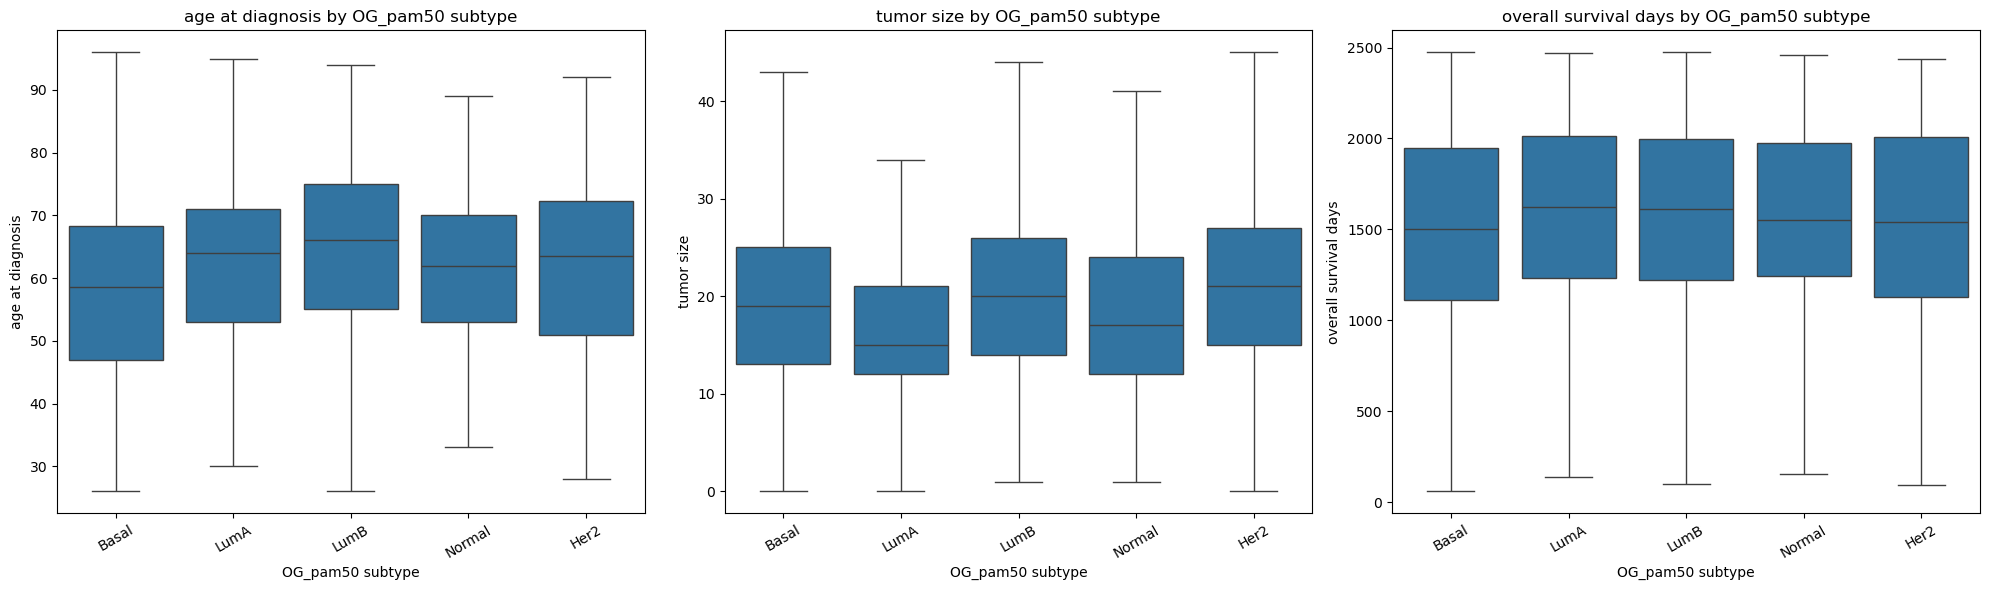

Kruskal-Wallis H-test Results
age at diagnosis: H-statistic=54.888, p-value=3.430e-11
tumor size: H-statistic=165.148, p-value=1.150e-34
overall survival days: H-statistic=16.171, p-value=2.799e-03


In [12]:
continuous4 = continuous_nonbinary
group_col = "OG_pam50 subtype"

fig, axes = plt.subplots(1,3, figsize=(20, 6))
axes = axes.flatten()

for i, col in enumerate(continuous4):
    sns.boxplot(x=df[group_col], y=df[col], ax=axes[i], showfliers=False)
    axes[i].set_title(f"{col} by {group_col}")
    axes[i].set_xlabel(group_col)
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


print("Kruskal-Wallis H-test Results\n" + "="*30)
for col in continuous4:
    # Drop NA for current analysis
    data = [group[col].dropna().values for name, group in df.groupby(group_col)]
    try:
        stat, p = kruskal(*data)
        print(f"{col}: H-statistic={stat:.3f}, p-value={p:.3e}")
    except ValueError:
        print(f"{col}: Not enough data for all groups, test not performed.")

# Expression Matrix


## Identifying Gene Variance

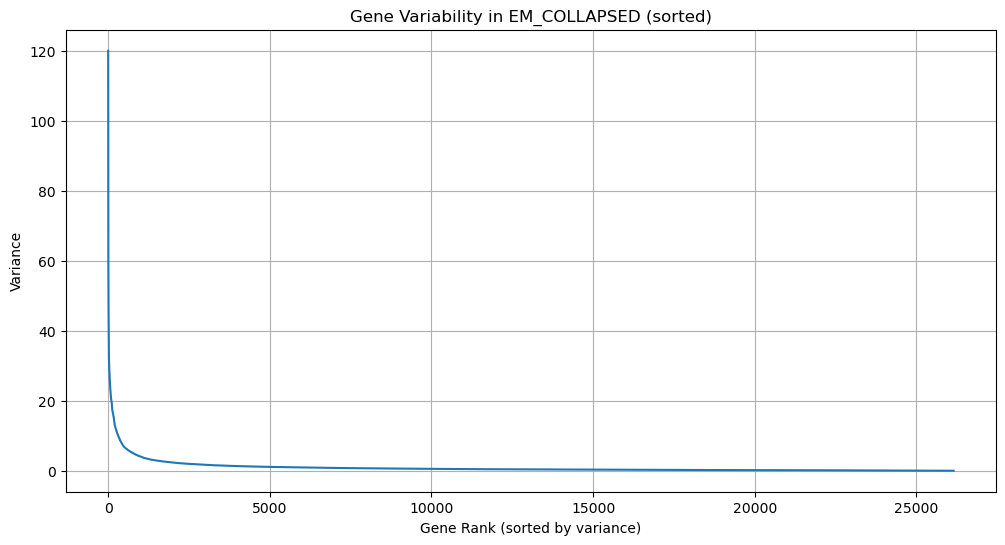

In [13]:
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

repo_root = find_repo_root()
expression_path = repo_root / os.getenv("EM_COLLAPSED")
expression = pd.read_csv(expression_path, index_col=0)

# Calculate variance for each gene (column)
gene_variances = expression.var(axis=0).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
plt.plot(range(1, len(gene_variances)+1), gene_variances.values)
plt.xlabel("Gene Rank (sorted by variance)")
plt.ylabel("Variance")
plt.title("Gene Variability in EM_COLLAPSED (sorted)")
plt.grid(True)
plt.show()